## Classifying documents

In this project, you will embark on the exciting task of classifying news articles for a content search engine. The goal is to build a model that can automatically categorize news articles into different topics or classes, enabling the search engine to deliver relevant content to users efficiently. To achieve this, you will leverage the powerful torchtext library, which simplifies the process of creating a dataset for text classification analysis.

With torchtext, you'll have the flexibility to access and preprocess raw news data effortlessly. The library enables you to convert text strings into torch.Tensors, which are essential for training machine learning models. By using torchtext's convenient functionalities, you can set up an efficient data processing pipeline that prepares your text data for classification.

Throughout this tutorial, you'll demonstrate how to effectively shuffle and iterate through the processed data using torch.utils.data.DataLoader. This DataLoader simplifies the data handling process, allowing you to focus on building and training your text classification model effectively.


#### Objectives

After completing this lab, you will be able to:

Work with datasets and understand tokenizer, embedding bag technique and vocabulary.
Explore embeddings in PyTorch and understand token indices.
Perform text classification using data loader and apply it on a neural network model.
Train the text classification model on a news dataset.
Engage in various exercises to solidify your understanding.

In [1]:
# libraries 

from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np
from torchtext.datasets import AG_NEWS
from IPython.display import Markdown as md
from tqdm import tqdm

from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from sklearn.manifold import TSNE
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split

from torchtext.data.utils import get_tokenizer

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


/opt/homebrew/Caskroom/mambaforge/base/envs/spacy-fr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defining helper functions

In [2]:
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

### Text classification 
Let's build a text class model using pytorch and torchtext to classify news articles into one of the four categories: World, Sports, Business and sci/tech

In [3]:
# importing blank dataset 
train_iter = iter(AG_NEWS(split='train'))

In [4]:
y, text = next((train_iter))
print(y, text)

3 Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


In [5]:
# classes 
ag_news_label = {1:"World", 2: "Sport", 3: "Business", 4: "Sci/Tec"}

ag_news_label[y]

'Business'

In [6]:
num_class = len(set([label for (label, text) in train_iter ]))
num_class 

4

creating the tokens

In [7]:
# Reinitialize train_iter
train_iter = AG_NEWS(split="train")

# define tokenizer and yield_tokens
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text.lower()) 

# Build vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])


print(f"Vocabulary size: {len(vocab)}")
print(f"Sample tokens: {list(vocab.get_stoi().keys())[:10]}")


Vocabulary size: 95811
Sample tokens: ['zyprexa', 'zwiki', 'zurab', 'zuhua', 'zubrin', 'zovko', 'zotinca', 'zos', 'zoology', 'zoner']


In [8]:
vocab(["age", "hello"])

[2120, 12544]

### Dataset

In [9]:
train_iter, test_iter = AG_NEWS()

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset)*0.95) # 5% data for validation

split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

In [10]:
# cheking if cuda-compatible

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

### data loader

preparing the text processing pipeline with the tokenizer and vocabulary. 

The function **```text_pipeline```** will tokenize the input text, and **```vocab```** will then be applied to get the token indices. 
The **```label_pipeline```** will ensure that the labels start at zero.

In [11]:
def text_pipeline(x):
    return vocab(tokenizer(x))


def label_pipeline(x):
    return int(x) - 1

In PyTorch, the **`collate_fn`** function is used in conjunction with data loaders to customize the way batches are created from individual samples.

It applies the `label_pipeline` and `text_pipeline` functions to preprocess the labels and texts, respectively. The processed data is then converted into PyTorch tensors and returned as a tuple containing the label tensor, text tensor, and offsets tensor representing the starting positions of each text sequence in the combined tensor. The function also ensures that the returned tensors are moved to the specified device (e.g., GPU) for efficient computation.


In [12]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]

    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)


        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
        

Convert the dataset objects to a data loader by applying the collate function

In [13]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)


valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)


In [14]:
label, text, offsets = next(iter(valid_dataloader))

label, text, offsets

(tensor([0, 2, 0, 1, 2, 1, 0, 1, 0, 1, 1, 2, 0, 0, 3, 1, 0, 0, 0, 1, 3, 3, 2, 2,
         2, 3, 2, 1, 3, 3, 2, 1, 0, 3, 2, 1, 1, 1, 0, 3, 0, 3, 2, 2, 3, 3, 2, 1,
         0, 0, 3, 1, 2, 3, 2, 0, 2, 1, 1, 3, 0, 3, 1, 3]),
 tensor([ 1568, 23616,   110,  ...,     6,  7504,     1]),
 tensor([   0,   59,  108,  148,  184,  240,  287,  329,  410,  438,  490,  525,
          585,  627,  666,  729,  775,  817,  870,  916,  949,  983, 1013, 1059,
         1091, 1127, 1150, 1193, 1254, 1299, 1372, 1410, 1452, 1479, 1517, 1561,
         1608, 1653, 1691, 1713, 1753, 1787, 1821, 1864, 1891, 1993, 2069, 2111,
         2159, 2206, 2242, 2285, 2323, 2354, 2384, 2417, 2455, 2501, 2546, 2587,
         2635, 2691, 2735, 2778]))

### Neural network

You have created a neural network for a text classification model using an EmeddingBag layor, followed by a softmax output layer. Additionally, you have initialized the model using a specific method:

In [15]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()


    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()


    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)



In [16]:
# set the embedding dimension size

emsize = 64

In [17]:
# set vocab size

vocab_size = len(vocab)
vocab_size

95811

In [18]:
num_class

4

In [19]:
# creating the model

model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

model

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [20]:
# predictions

predicted_label = model(text, offsets)

In [21]:
predicted_label.shape

torch.Size([64, 4])

Function **`predict`** takes in a text and a text pipeline, which preprocesses the text for machine learning. It uses a pre-trained model to predict the label of the text for text classification on the AG_NEWS dataset. The function returns the predicted label as a result.


In [22]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return ag_news_label[output.argmax(1).item() + 1]

In [23]:
predict("Elon Musk is building a rocket", text_pipeline)

'Business'

In [24]:
# creating function to evaluate models accuracy

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0 

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count

In [25]:
evaluate(test_dataloader)

0.23921052631578948

it's a low score but it's understandable given that the model isn't trained yet

In [26]:
LR = 0.1

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [27]:
# training the model (could take time)

EPOCHS = 10
cum_loss_list = []
acc_epoch = []
acc_old = 0


for epoch in tqdm(range(1, EPOCHS + 1)):
    model.train()
    cum_loss = 0
    for idx, (label, text, offsets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        cum_loss += loss.item()


    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
        acc_old = accu_val
        torch.save(model.state_dict(), '01_homework_model.pth')





  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:20<00:00,  8.01s/it]


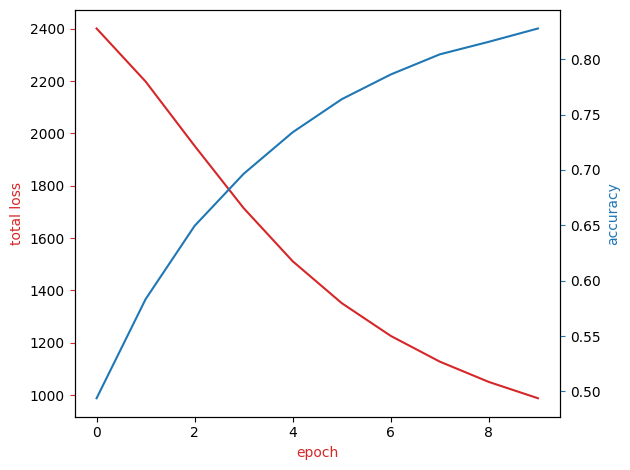

In [28]:
plot(cum_loss_list, acc_epoch)

In [29]:
evaluate(test_dataloader) 

0.8128947368421052

a lot better than previously

This code snippet provides a summary for generating a 3D t-SNE visualization of embeddings using Plotly. It demonstrates how words that are similar to each other are positioned closer together.


In [30]:
# Get the first batch from the validation data
batch = next(iter(valid_dataloader))

# Extract the text and offsets from the batch
label, text, offsets = batch

# Send the data to the device (GPU if available)
text = text.to(device)
offsets = offsets.to(device)

# Get the embeddings bag output for the batch
embedded = model.embedding(text, offsets)

# Convert the embeddings tensor to a numpy array
embeddings_numpy = embedded.detach().cpu().numpy()

# Perform t-SNE on the embeddings to reduce their dimensionality to 3D.
X_embedded_3d = TSNE(n_components=3).fit_transform(embeddings_numpy)

# Create a 3D scatter plot using Plotly
trace = go.Scatter3d(
    x=X_embedded_3d[:, 0],
    y=X_embedded_3d[:, 1],
    z=X_embedded_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=label.numpy(),  # Use label information for color
        colorscale='Viridis',  # Choose a colorscale
        opacity=0.8
    )
)

layout = go.Layout(title="3D t-SNE Visualization of Embeddings",
                   scene=dict(xaxis_title='Dimension 1',
                              yaxis_title='Dimension 2',
                              zaxis_title='Dimension 3'))

fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [31]:
# predicting my own article
article = """Global markets faced renewed pressure on Wednesday after weaker-than-expected manufacturing data from China raised fresh concerns about the pace of the global economic recovery. 
Investors responded with caution as major indexes in Europe and Asia saw modest declines, while the US dollar gained against several currencies viewed as risk-sensitive. 
Adding to the uncertainty, Goldman Sachs revised its global GDP growth forecast downward by 0.2%, citing persistent supply chain disruptions and soft demand from key export markets. 
“While inflation has been trending downwards, we now see mounting evidence that industrial activity is cooling faster than anticipated,” said Jan Hatzius, Chief Economist at Goldman Sachs.
Despite the downgrade, Goldman analysts maintain a cautiously optimistic outlook for Q4, pointing to resilient labor markets in the US and easing energy prices in Europe as potential stabilizing factors.
Market watchers now turn their attention to upcoming central bank meetings, where policymakers will weigh recent data against ongoing inflation risks to determine the path forward."""



In [32]:
result = predict(article, text_pipeline)

markdown_content = f'''
<div style="background-color: lightgray; padding: 10px;">
    <h3>{article}</h3>
    <h4>The category of the news article: {result}</h4>
</div>
'''

md(markdown_content)


<div style="background-color: lightgray; padding: 10px;">
    <h3>Global markets faced renewed pressure on Wednesday after weaker-than-expected manufacturing data from China raised fresh concerns about the pace of the global economic recovery. 
Investors responded with caution as major indexes in Europe and Asia saw modest declines, while the US dollar gained against several currencies viewed as risk-sensitive. 
Adding to the uncertainty, Goldman Sachs revised its global GDP growth forecast downward by 0.2%, citing persistent supply chain disruptions and soft demand from key export markets. 
“While inflation has been trending downwards, we now see mounting evidence that industrial activity is cooling faster than anticipated,” said Jan Hatzius, Chief Economist at Goldman Sachs.
Despite the downgrade, Goldman analysts maintain a cautiously optimistic outlook for Q4, pointing to resilient labor markets in the US and easing energy prices in Europe as potential stabilizing factors.
Market watchers now turn their attention to upcoming central bank meetings, where policymakers will weigh recent data against ongoing inflation risks to determine the path forward.</h3>
    <h4>The category of the news article: Business</h4>
</div>


### Exercises:

- Load the pre-trained model

- Define a list of new articles for classification


- Dlassify each article and display the results

In [55]:
# Loading
pretrained_model = torch.load("./01_homework_model.pth")

In [57]:
pretrained_model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
pretrained_model.load_state_dict(torch.load("01_homework_model.pth"))
pretrained_model.eval()

TextClassificationModel(
  (embedding): EmbeddingBag(95811, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [60]:
# List of articles
import torch

# Assuming you already have:
# model, vocab, tokenizer, and ag_news_label defined
# Also, make sure your model is in eval mode
#pretrained_model.eval()

# Text pipeline: converts text into token indices
def text_pipeline(x):
    return vocab(tokenizer(x))

# List of (text, actual_label)
articles = [
    ("UN urges immediate ceasefire as humanitarian crisis deepens in Gaza...", 1),
    ("Spain clinches thrilling 2-1 victory over Brazil in World Cup semi-final...", 2),
    ("Goldman Sachs upgrades economic growth forecast for Q3...", 3),
    ("NASA’s James Webb telescope captures most detailed images yet of exoplanets...", 4),
    ("South Korea and Japan agree to strengthen military cooperation...", 1),
    ("Novak Djokovic wins 24th Grand Slam title after dominating...", 2),
    ("Tesla shares surge 6% after the company announces record-breaking...", 3),
    ("OpenAI announces new GPT-5 architecture...", 4),
    ("Massive floods displace thousands in eastern Bangladesh...", 1),
    ("Goldman Sachs eyes expansion into Southeast Asia...", 3),
]

# Evaluate each article

def predicting_new_articles(model, articles):
    correct = 0
    for i, (text, actual_label) in enumerate(articles, 1):
        with torch.no_grad():
            input_tensor = torch.tensor(text_pipeline(text), dtype=torch.int64)
            offsets = torch.tensor([0])
            output = model(input_tensor, offsets)
            predicted_label = output.argmax(1).item()

            pred_name = ag_news_label[predicted_label + 1]  # add 1 because labels start from 0 in model
            actual_name = ag_news_label[actual_label]

            match = predicted_label + 1 == actual_label
            if match:
                correct += 1

            print(f"{i}. Predicted: {pred_name:10} | Actual: {actual_name:10} | Match: {match}")
            print(f'article: {text[0:100]}...')
            print("*"*5)

    # Accuracy summary
    accuracy = correct / len(articles)
    print(f"\nAccuracy on 10 custom samples: {accuracy * 100:.2f}%")



In [61]:
# Method for predicting
predicting_new_articles(pretrained_model, articles)


1. Predicted: World      | Actual: World      | Match: True
article: UN urges immediate ceasefire as humanitarian crisis deepens in Gaza......
*****
2. Predicted: Sport      | Actual: Sport      | Match: True
article: Spain clinches thrilling 2-1 victory over Brazil in World Cup semi-final......
*****
3. Predicted: Business   | Actual: Business   | Match: True
article: Goldman Sachs upgrades economic growth forecast for Q3......
*****
4. Predicted: World      | Actual: Sci/Tec    | Match: False
article: NASA’s James Webb telescope captures most detailed images yet of exoplanets......
*****
5. Predicted: World      | Actual: World      | Match: True
article: South Korea and Japan agree to strengthen military cooperation......
*****
6. Predicted: Sport      | Actual: Sport      | Match: True
article: Novak Djokovic wins 24th Grand Slam title after dominating......
*****
7. Predicted: Business   | Actual: Business   | Match: True
article: Tesla shares surge 6% after the company announces 